In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 5 Matrix Factorization Visualizations

Load in each data file:

In [2]:
data = np.loadtxt('data/data.txt', skiprows=0, delimiter='\t', dtype='int')
test = np.loadtxt('data/test.txt', skiprows=0, delimiter='\t', dtype='int')
train = np.loadtxt('data/train.txt', skiprows=0, delimiter='\t', dtype='int')
movies = np.loadtxt('data/movies.txt', skiprows=0, delimiter='\t', dtype='str')

Here we generate the ratings list

In [3]:
totalRatings = {}
for element in data:
    if element[1] in totalRatings:
        totalRatings[element[1]] += 1
    else:
        totalRatings[element[1]] = 1

ratingList = []

for item in totalRatings.items():
    ratingList.append(item)
    
ratingList.sort(key=lambda x: x[1], reverse=True)

Now get the average ratings

In [4]:
avgRatings = {}
for element in data:
    if element[1] in avgRatings:
        avgRatings[element[1]][0] += int(element[2])
        avgRatings[element[1]][1] += 1
    else:
        avgRatings[element[1]] = [int(element[2]), 1]

        
avgRatingList = []

for key, value in avgRatings.items():
    avgRatingList.append((key, value[0] / float(value[1])))
    
avgRatingList.sort(key=lambda x: x[1], reverse=True)

### Part 1

Below is my code from Homework 5:

In [5]:
import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - np.dot(Vj, (Yij - np.dot(Ui, Vj))))
       
def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - np.dot(Ui, (Yij - np.dot(Ui, Vj))))

def get_err(U, V, Y, reg=0.1):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    # Sum of the squared loss
    summation = 0
    for element in Y:
        i = element[0]
        j = element[1]
        Y_ij = element[2]
        summation += ((Y_ij - np.dot(U[i - 1], V[j - 1])) ** 2)
    
    # Norm squared U 
    fro_U = 0
    for x in range(len(U)):
        for y in range(len(U[0])):
            fro_U += (U[x][y] ** 2)

    # Norm squared V 
    fro_V = 0
    for x in range(len(V)):
        for y in range(len(V[0])):
            fro_V += (V[x][y] ** 2)
    
    # Divide by the length of Y since its mean squared error
    return ((reg / 2) * (fro_U + fro_V) + 0.5 * summation) / len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    U = []
    V = []
    
    # Initialize the U and V matrixes
    for i in range(M):
        temp = []
        for j in range(K):
            temp.append(np.random.uniform(-0.5, 0.5))
        U.append(temp)
        
    for i in range(N):
        temp = []
        for j in range(K):
            temp.append(np.random.uniform(-0.5, 0.5))
        V.append(temp)   
    U = np.array(U)
    V = np.array(V)
    
    # Now, run the algorithm
    loss_reduct_0 = 0
    loss_prev = get_err(U, V, Y)
    for i in range(max_epochs):
        
        # Shuffle order of datapoints
        indices = np.random.permutation(len(Y))
        for index in indices:
            
            # Update U using the ith row of U. The data is 1 indexed so we must change this to 
            # 0 indexed
            U[Y[index][0] - 1] = U[Y[index][0] - 1] - grad_U(U[Y[index][0] - 1], Y[index][2], V[Y[index][1] - 1], reg, eta)
            
            # Update V using the jth column of V
            V[Y[index][1] - 1] = V[Y[index][1] - 1] - grad_V(V[Y[index][1] - 1], Y[index][2], U[Y[index][0] - 1], reg, eta)

        if i == 0:
            loss_reduct_0 = loss_prev - get_err(U, V, Y)
        
        if (loss_prev - get_err(U, V, Y)) / loss_reduct_0 <= eps:
            break
            
        loss_prev = get_err(U, V, Y)
    
    # Calculate mean unregularized error
    summation = 0
    for element in Y:
        i = element[0]
        j = element[1]
        Y_ij = element[2]
        summation += ((Y_ij - np.dot(U[i - 1], V[j - 1])) ** 2)
        
    return (U, V, summation / (2 * len(Y)))

We will use a regularization parameter of $\lambda=0.1$ since this performed best on the test set in the homework. Our stop criteria will be 300 epochs since this is probably enough epochs to converge if the model is able to converge to a particular value, and our other stop condition will be if the change over an epoch is very small relative to the change over the first epoch, which indicates that the model has basically converged. Use 0.03 for the learning rate as it is small enough for gradient descent to approach a global minimum but large enough that it doesn't take too many epoches to converge.

First, run matrix factorization to get values of U and V

In [100]:
M = 943
N = 1682

Y = train
U,V, err = train_model(M, N, 20, 0.03, 0.1, Y)

Now, print the train and test errors:

In [101]:
print("train error: " + str(get_err(U, V, Y, reg=0.0)))
print("test error: " + str(get_err(U, V, test, reg=0.0)))

train error: 0.30294619553161
test error: 0.44690325462117597


#### 1)

Apply SVD:

In [102]:
A, Sigma, B = np.linalg.svd(np.transpose(V))
A_u, Sigma_u, B_u = np.linalg.svd(np.transpose(U))

Now, get $U_{tilda}$ and $V_{tilda}$.

In [103]:
U_tilda = np.dot(np.transpose(A_u[:,:2]), np.transpose(U))
V_tilda = np.dot(np.transpose(A[:,:2]), np.transpose(V))

#### 2)

Now, construct 2-D visualizations using $V_{tilda}$. First, note that in $V_{tilda}$, each row corresponds to a movie. Since in A, each of the 20 rows corresponds to a particular movie "concept", the two rows we're using correspond to the two most important concepts in classifying movies, and so each column in $V_{tilda}$ corresponds to each movies' score for a particular concept.

##### a)

For the ten movies, we choose Star Wars (1977) (index 50), Stand by Me (1986) (index 655), Naked (1993) (index 960), Toy Story (1995) (index 1), It's a Wonderful Life (1946) (index 491), Pulp Fiction (1994) (index 56), "Shawshank Redemption, The (1994)" (index 64), Forrest Gump (1994) (index 69), Hercules (1997) (index 993), Titanic (1997) (index 313)

For each one of these movies, pull out the corresponding values from the $V_{tilda}$ matrix

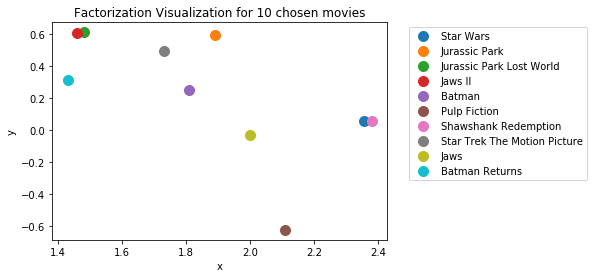

In [121]:
plt.plot([V_tilda[0][49]], [V_tilda[1][49]], 'o', markersize=10, label='Star Wars')
plt.plot([V_tilda[0][81]], [V_tilda[1][81]], 'o', markersize=10, label='Jurassic Park')
plt.plot([V_tilda[0][251]], [V_tilda[1][251]], 'o', markersize=10, \
         label='Jurassic Park Lost World')
plt.plot([V_tilda[0][451]], [V_tilda[1][451]], 'o', markersize=10, label='Jaws II')
plt.plot([V_tilda[0][402]], [V_tilda[1][402]], 'o', markersize=10, \
         label='Batman')
plt.plot([V_tilda[0][55]], [V_tilda[1][55]], 'o', markersize=10, label='Pulp Fiction')
plt.plot([V_tilda[0][63]], [V_tilda[1][63]], 'o', markersize=10, \
         label='Shawshank Redemption')
plt.plot([V_tilda[0][448]], [V_tilda[1][448]], 'o', markersize=10, label='Star Trek \
The Motion Picture')
plt.plot([V_tilda[0][233]], [V_tilda[1][233]], 'o', markersize=10, label='Jaws')
plt.plot([V_tilda[0][230]], [V_tilda[1][230]], 'o', markersize=10, label='Batman Returns')

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Factorization Visualization for 10 chosen movies')
plt.ylabel('y')
plt.xlabel('x')

plt.show()

##### b)

Now, we plot the ten most popular movies. From the ratingList array, we have the movie index stored along with the number of ratings. We will use the movie index to find the value:

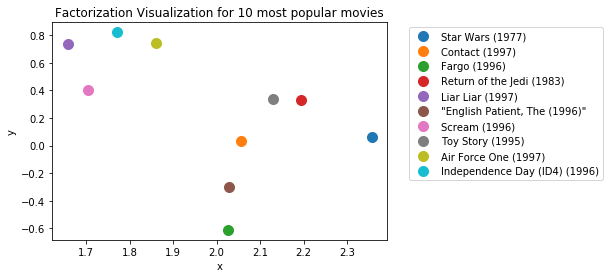

In [122]:
for element in ratingList[:10]:
    index = element[0]
    label = movies[index - 1][1]
    plt.plot([V_tilda[0][index - 1]], \
             [V_tilda[1][index - 1]], 'o', markersize=10, label=label)

plt.title('Factorization Visualization for 10 most popular movies')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

##### c)

Now plot the best movies:

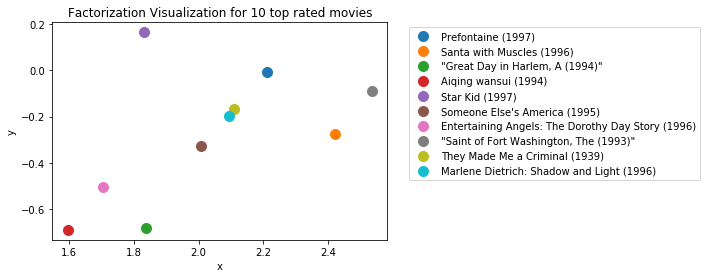

In [123]:
for element in avgRatingList[:10]:
    index = element[0]
    label = movies[index - 1][1]
    plt.plot([V_tilda[0][index - 1]], \
             [V_tilda[1][index - 1]], 'o', markersize=10, label=label)

plt.title('Factorization Visualization for 10 top rated movies')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

##### d)

For this problem, we will just go through the movies list and pull the first 10 movies we see from each of the 3 categories.

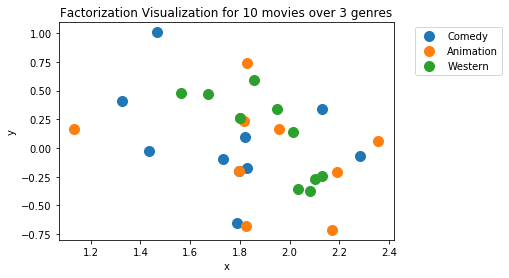

In [107]:
# Find the movie IDs
comedy = []
western = []
animation = []

i = 0
j = 0
k = 0
for item in movies:
    if i == 10 and j == 10 and k == 10:
        break
        
    # Append the movie ID
    if int(item[7]) == 1 and i < 10:
        comedy.append(int(item[0]))
        i += 1
    if int(item[16]) == 1 and j < 10:
        animation.append(int(item[0]))
        j += 1
    if int(item[20]) == 1 and k < 10:
        western.append(int(item[0]))
        k += 1

# Find the values in V_tilda corresponding
# to the movies. Each of the arrays below
# will contain separate arrays that correspond to 
# V_tilda's columns
comedy2 = [[], []]
western2 = [[], []]
animation2 = [[], []]

for element in comedy:
    index = element
    comedy2[0].append(V_tilda[0][index - 1])
    comedy2[1].append(V_tilda[1][index - 1])

for element in western:
    index = element
    western2[0].append(V_tilda[0][index - 1])
    western2[1].append(V_tilda[1][index - 1])

for element in animation:
    index = element
    animation2[0].append(V_tilda[0][index - 1])
    animation2[1].append(V_tilda[1][index - 1])

# Now, plot the values
plt.plot(comedy2[0], \
         comedy2[1], 'o', markersize=10, label='Comedy')

plt.plot(animation2[0], \
         animation2[1], 'o', markersize=10, label='Animation')

plt.plot(western2[0], \
         western2[1], 'o', markersize=10, label='Western')

plt.title('Factorization Visualization for 10 movies over 3 genres')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

##### Extra Exploratory Data Analysis

Plot all the data:

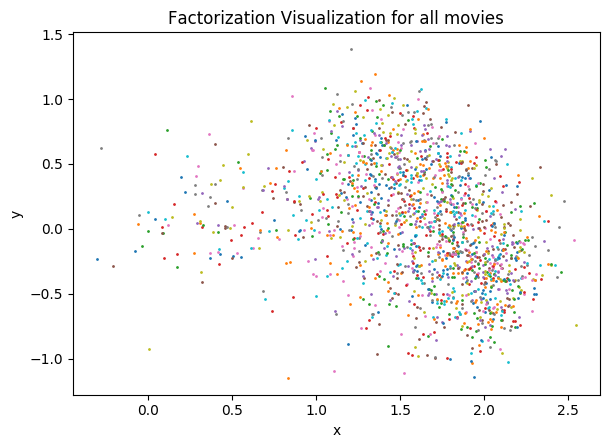

In [120]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')

for element in movies:
    index = int(element[0])
    label = movies[index - 1][1]
    plt.plot([V_tilda[0][index - 1]], \
             [V_tilda[1][index - 1]], 'o', markersize=1, label=label)

#plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

plt.title('Factorization Visualization for all movies')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

Also, we can look at the average position, based off the movie category

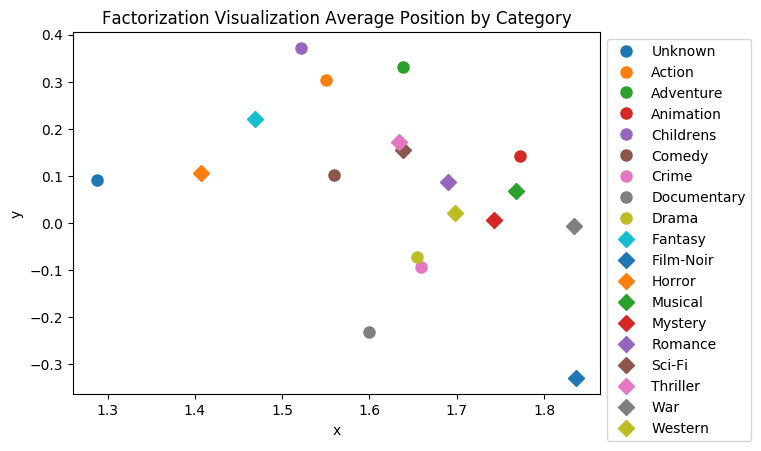

In [124]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')

counts = [0] * (len(movies[0]) - 2)
totals = np.zeros(((len(movies[0]) - 2), 2))

for movie in movies[:]:
    index = int(movie[0]) - 1
    for j in range(len(movie) - 2):
        if movie[j + 2] == '1':
            totals[j][0] += V_tilda[0][index]
            totals[j][1] += V_tilda[1][index]
            counts[j] += 1
categories = ['Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

for i in range(int(len(counts) / 2)):
    plt.plot(totals[i][0] / counts[i], totals[i][1] / counts[i], 'o', markersize=8, label=categories[i])
    
for i in range(int(len(counts) / 2), len(counts)):
    plt.plot(totals[i][0] / counts[i], totals[i][1] / counts[i], 'D', markersize=8, label=categories[i])

plt.title('Factorization Visualization Average Position by Category')
plt.ylabel('y')
plt.xlabel('x')

plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.show()

Here, we can graph all movies, grouped by number of categories a movie falls into

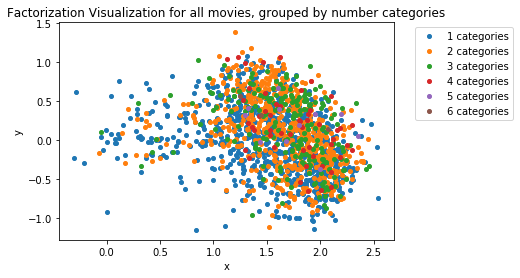

In [125]:
# there are 18 categories excluding unknown
ratings = []
for i in range(18):
    ratings.append([])

for element in movies:
    count = 0
    for i in range(3, 21):
        if int(element[i]) == 1:
            count += 1
    if count > 0:
        ratings[count - 1].append(int(element[0]))

ratings2 = [[[], []], [[], []], [[], []], [[], []], [[], []], [[], []]]
for i in range(6):
    for element in ratings[i]:
        index = element
        ratings2[i][0].append(V_tilda[0][index - 1])
        ratings2[i][1].append(V_tilda[1][index - 1])

for i in range(len(ratings2)):
    label = str(i + 1) + " categories"
    plt.plot(ratings2[i][0], \
             ratings2[i][1], 'o', markersize=4, label=label)
    
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

plt.title('Factorization Visualization for all movies, grouped by number categories')
plt.ylabel('y')
plt.xlabel('x')
plt.show()


In [110]:
ratings3 = [ratings2[0], ratings2[1], ratings2[2], [[], []]]

for i in range(len(ratings2[3][0])):
    ratings3[3][0].append(ratings2[3][0][i])
    ratings3[3][1].append(ratings2[3][1][i])
    
for i in range(len(ratings2[4][0])):
    ratings3[3][0].append(ratings2[4][0][i])
    ratings3[3][1].append(ratings2[4][1][i])
    
for i in range(len(ratings2[5][0])):
    ratings3[3][0].append(ratings2[5][0][i])
    ratings3[3][1].append(ratings2[5][1][i])



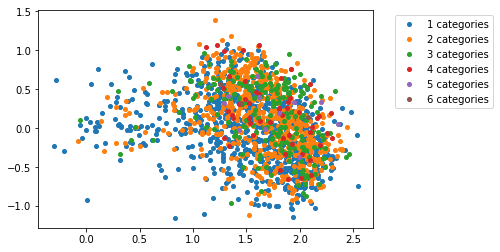

In [111]:
for i in range(len(ratings2)):
    label = str(i + 1) + " categories"
    plt.plot(ratings2[i][0], \
             ratings2[i][1], 'o', markersize=4, label=label)
    
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()
plt.show()

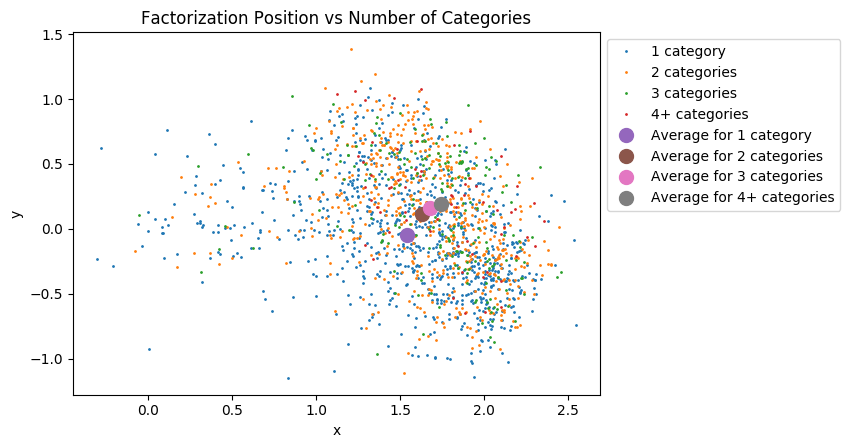

In [114]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
plt.plot(ratings3[0][0], \
         ratings3[0][1], 'o', markersize=1, label='1 category')

plt.plot(ratings3[1][0], \
         ratings3[1][1], 'o', markersize=1, label='2 categories')

plt.plot(ratings3[2][0], \
         ratings3[2][1], 'o', markersize=1, label='3 categories')

plt.plot(ratings3[3][0], \
         ratings3[3][1], 'o', markersize=1, label='4+ categories')


plt.plot([np.mean(np.array(ratings3[0][0]))], \
         [np.mean(np.array(ratings3[0][1]))], 'o', markersize=10, \
         label='Average for 1 category')

plt.plot([np.mean(np.array(ratings3[1][0]))], \
         [np.mean(np.array(ratings3[1][1]))], 'o', markersize=10, \
         label='Average for 2 categories')

plt.plot([np.mean(np.array(ratings3[2][0]))], \
         [np.mean(np.array(ratings3[2][1]))], 'o', markersize=10, \
         label='Average for 3 categories')

plt.plot([np.mean(np.array(ratings3[3][0]))], \
         [np.mean(np.array(ratings3[3][1]))], 'o', markersize=10, \
         label='Average for 4+ categories')

plt.legend(loc=2, bbox_to_anchor=(1, 1))
# plt.savefig('Images/all.png')
plt.title('Factorization Position vs Number of Categories')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

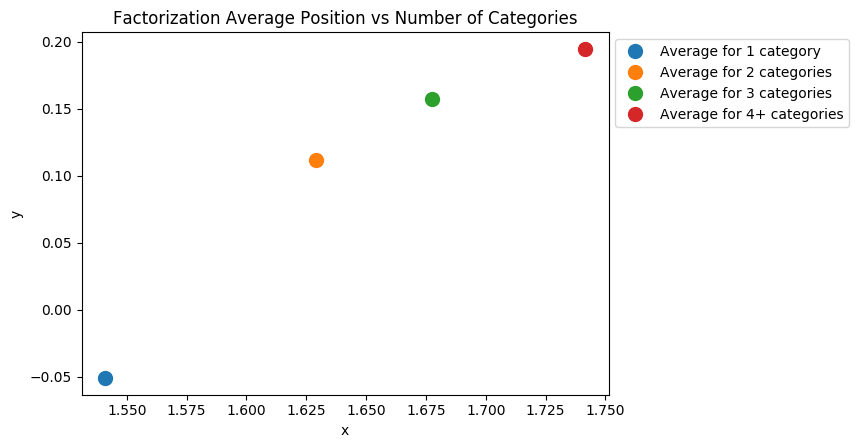

In [115]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')

plt.plot([np.mean(np.array(ratings3[0][0]))], \
         [np.mean(np.array(ratings3[0][1]))], 'o', markersize=10, \
         label='Average for 1 category')

plt.plot([np.mean(np.array(ratings3[1][0]))], \
         [np.mean(np.array(ratings3[1][1]))], 'o', markersize=10, \
         label='Average for 2 categories')

plt.plot([np.mean(np.array(ratings3[2][0]))], \
         [np.mean(np.array(ratings3[2][1]))], 'o', markersize=10, \
         label='Average for 3 categories')

plt.plot([np.mean(np.array(ratings3[3][0]))], \
         [np.mean(np.array(ratings3[3][1]))], 'o', markersize=10, \
         label='Average for 4+ categories')

plt.legend(loc=2, bbox_to_anchor=(1, 1))
# plt.savefig('Images/zoom.png')
plt.title('Factorization Average Position vs Number of Categories')
plt.ylabel('y')
plt.xlabel('x')
plt.show()